# Garbage Classification

**Credit: [AITS cainvas](http://cainvas.ai-tech.systems/) authors**

![](https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/garbage_classification.gif)

Separating recyclable waste materials is the basis for any recycling process. 

In many cases waste is not separated at the house level. A deep learning model can be used to separate the different components of garbage automatically at the recovering facilities or biological treatment systems with high efficiency.

This notebook classifies wastes into 6 categories - glass, cardboard, paper, plastic and metal.

In [1]:
import numpy as np
import os
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models, optimizers
import random
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from PIL import Image

## Dataset

The dataset has 2 folders - train and test.

Each of these has sub-folders containing images belonging to a specific class which is specified as the sub-folder name

In [2]:
!wget https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Garbage_classification.zip

!unzip -qo Garbage_classification.zip

# zip folder is not needed anymore
!rm Garbage_classification.zip

--2020-11-06 05:54:34--  https://cainvas-static.s3.amazonaws.com/media/user_data/cainvas-admin/Garbage_classification.zip
Resolving cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)... 52.219.64.60
Connecting to cainvas-static.s3.amazonaws.com (cainvas-static.s3.amazonaws.com)|52.219.64.60|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 42074220 (40M) [application/zip]
Saving to: ‘Garbage_classification.zip’

Garbage_classificat 100%[===================>]  40.12M   101MB/s    in 0.4s    

2020-11-06 05:54:34 (101 MB/s) - ‘Garbage_classification.zip’ saved [42074220/42074220]



In [3]:
# Loading the dataset

path = 'Garbage classification/'

batch = 32

# The train and test datasets
print("Train dataset")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(path+'train', batch_size=batch)

print("Test dataset")
test_ds = tf.keras.preprocessing.image_dataset_from_directory(path+'test', batch_size=batch)

Train dataset
Found 1910 files belonging to 5 classes.
Test dataset
Found 480 files belonging to 5 classes.


In [4]:
# How may samples in each class

for t in ['train', 'test']:
    print('\n', t.upper())
    for x in os.listdir(path + t):
        print(x, ' - ', len(os.listdir(path + t + '/' + x)))


 TRAIN
paper  -  475
metal  -  328
plastic  -  385
glass  -  400
cardboard  -  322

 TEST
paper  -  119
metal  -  82
plastic  -  97
glass  -  101
cardboard  -  81


In [5]:
# Looking into the class labels

class_names = train_ds.class_names

print("Train class names: ", train_ds.class_names)
print("Test class names: ", test_ds.class_names)

Train class names:  ['cardboard', 'glass', 'metal', 'paper', 'plastic']
Test class names:  ['cardboard', 'glass', 'metal', 'paper', 'plastic']


In [6]:
# Looking into the shape of the batches and individual samples
# Set the input shape

print("Looking into the shape of images and labels in one batch\n")  

for image_batch, labels_batch in train_ds:
    input_shape = image_batch[0].shape
    print("Shape of images input for one batch: ", image_batch.shape)
    print("Shape of images labels for one batch: ", labels_batch.shape)
    break

Looking into the shape of images and labels in one batch

Shape of images input for one batch:  (32, 256, 256, 3)
Shape of images labels for one batch:  (32,)


## Visualization

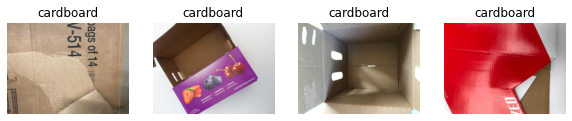

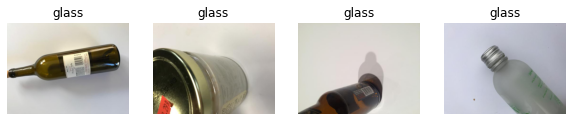

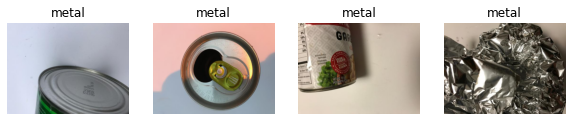

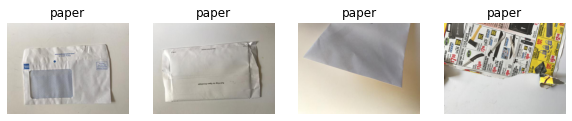

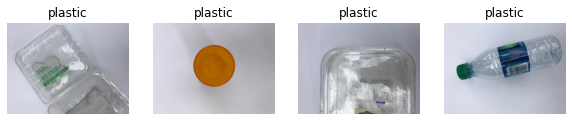

In [7]:
num_samples = 4    # the number of samples to be displayed in each class

for x in class_names:
    plt.figure(figsize=(10, 10))

    filenames = os.listdir(path + 'train/' + x)

    for i in range(num_samples):
        ax = plt.subplot(1, num_samples, i + 1)
        img = Image.open(path +'train/' + x + '/' + filenames[i])
        plt.imshow(img)
        plt.title(x)
        plt.axis("off")

## Preprocessing the data

In [8]:
# Normalizing the pixel values

normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

## The model

In [9]:
base_model = keras.applications.Xception(weights='imagenet', input_shape=input_shape, include_top=False)    # False, do not include the classification layer of the model

base_model.trainable = False

inputs = tf.keras.Input(shape=input_shape)

x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)
outputs = keras.layers.Dense(len(class_names), activation = 'softmax')(x)    # Add own classififcation layer

model = keras.Model(inputs, outputs)

In [10]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizers.Adam(0.001), metrics=['accuracy'])

history = model.fit(train_ds, validation_data =  test_ds, epochs=8)

Epoch 1/8
60/60 [==============================] - 269s 4s/step - loss: 0.8348 - accuracy: 0.7178 - val_loss: 0.5649 - val_accuracy: 0.8250
Epoch 2/8
60/60 [==============================] - 268s 4s/step - loss: 0.4549 - accuracy: 0.8482 - val_loss: 0.4831 - val_accuracy: 0.8417
Epoch 3/8
60/60 [==============================] - 269s 4s/step - loss: 0.3758 - accuracy: 0.8754 - val_loss: 0.4605 - val_accuracy: 0.8562
Epoch 4/8
60/60 [==============================] - 269s 4s/step - loss: 0.3263 - accuracy: 0.8921 - val_loss: 0.4433 - val_accuracy: 0.8542
Epoch 5/8
60/60 [==============================] - 268s 4s/step - loss: 0.2948 - accuracy: 0.9110 - val_loss: 0.4300 - val_accuracy: 0.8604
Epoch 6/8
60/60 [==============================] - 269s 4s/step - loss: 0.2598 - accuracy: 0.9225 - val_loss: 0.4283 - val_accuracy: 0.8542
Epoch 7/8
60/60 [==============================] - 271s 5s/step - loss: 0.2381 - accuracy: 0.9346 - val_loss: 0.4192 - val_accuracy: 0.8458
Epoch 8/8
60/60 [===

In [11]:
model.evaluate(test_ds)

15/15 [==============================] - 51s 3s/step - loss: 0.4246 - accuracy: 0.8708


[0.42461860179901123, 0.8708333373069763]

## Plotting the metrics

In [12]:
def plot(history, variable, variable1):
    plt.plot(range(len(history[variable])), history[variable])
    plt.plot(range(len(history[variable1])), history[variable1])
    plt.title(variable)
    plt.legend([variable, variable1])
    plt.title(variable)

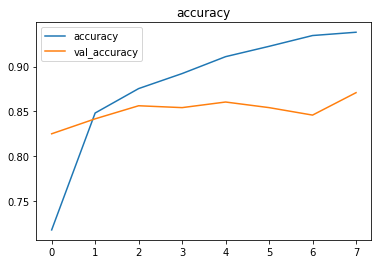

In [13]:
plot(history.history, "accuracy", "val_accuracy")

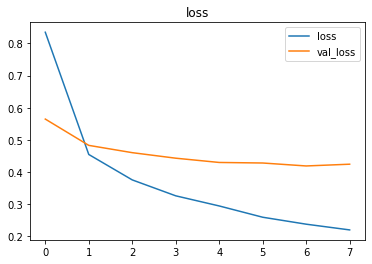

In [14]:
plot(history.history, "loss", "val_loss")

## Prediction

Prdicted:  plastic
True:  plastic
Probability:  0.4978912


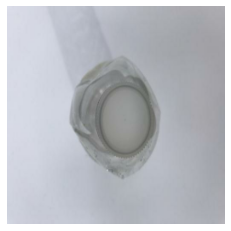

In [15]:
x = random.randint(0, batch - 1)

for i in test_ds.as_numpy_iterator():
    img, label = i    
    plt.axis('off')   # remove axes
    plt.imshow(img[x])    # shape from (32, 256, 256, 3) --> (256, 256, 3)
    output = model.predict(np.expand_dims(img[x],0))    # getting output; input shape (256, 256, 3) --> (1, 256, 256, 3)
    pred = np.argmax(output[0])    # finding max
    print("Prdicted: ", class_names[pred])    # Picking the label from class_names based on the model output
    print("True: ", class_names[label[x]])
    print("Probability: ", output[0][pred])
    break

## deepC

In [16]:
model.save('garbage_classification.h5')

!deepCC garbage_classification.h5

reading [keras model] from 'garbage_classification.h5'
Saved 'garbage_classification.onnx'
reading onnx model from file  garbage_classification.onnx
Model info:
  ir_vesion :  5 
  doc       : 
WARN (ONNX): graph-node conv2d's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block2_sepconv10's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block2_sepconv11's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block2_sepconv20's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block2_sepconv21's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node conv2d_1's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block3_sepconv10's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block3_sepconv11's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block3_sepconv20's attribute auto_pad has no meaningful data.
WARN (ONNX): graph-node block3_sepconv21's attribu